### Environment Setup: ModelNet & PyTorch3D

This section sets up the environment for 3D point cloud robustness experiments using PyTorch3D and ModelNet.

**Requirements:**
- PyTorch (with CUDA if available)
- PyTorch3D
- tqdm, matplotlib, numpy, pandas, scikit-learn

**Note:** PyTorch3D requires a compatible PyTorch version. See [https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md] for details.

In [2]:
# Install PyTorch3D (uncomment if not already installed)
# For CUDA 11.7 (adjust for your CUDA version):
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

# If you are on CPU-only, use:
# pip install torch torchvision torchaudio
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os  #new
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
#import os
import random
# PyTorch3D
try:
    import pytorch3d
    from pytorch3d.loss import chamfer_distance
    from pytorch3d.ops import sample_points_from_meshes
    print("PyTorch3D is installed and ready.")
except ImportError:
    print("PyTorch3D is not installed. Please follow the instructions above.")

PyTorch3D is installed and ready.


### Step 1: Download and Prepare ModelNet40 Data

We will download the ModelNet40 dataset, extract it, and preprocess it into point clouds.

- The dataset will be stored in a local directory (e.g., `./modelnet40`).
- Each mesh will be sampled into a fixed number of points (e.g., 1024) for use in point cloud classification.
- This step only needs to be run once.

In [7]:
#import os
import urllib.request
import zipfile

DATA_DIR = './modelnet40'
MODELNET_URL = 'http://modelnet.cs.princeton.edu/ModelNet40.zip'
ZIP_PATH = os.path.join(DATA_DIR, 'ModelNet40.zip')

# Download ModelNet40 if not present
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, 'ModelNet40')):
    print('Downloading ModelNet40...')
    urllib.request.urlretrieve(MODELNET_URL, ZIP_PATH)
    print('Extracting ModelNet40...')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print('Done.')
else:
    print('ModelNet40 already downloaded and extracted.')

ModelNet40 already downloaded and extracted.


### Step 2: Create a PyTorch Dataset and DataLoader for ModelNet40 Point Clouds

This step defines a PyTorch Dataset that loads ModelNet40 meshes, samples point clouds using PyTorch3D, and provides them for training and evaluation.

- Each sample is a tuple: (point_cloud [N, 3], label)
- The dataset supports on-the-fly mesh loading and point sampling.
- You can cache sampled point clouds for faster subsequent runs.

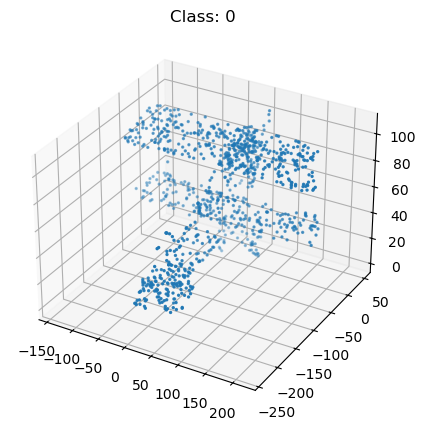

In [9]:
import glob
#import os
import numpy as np
import torch
import trimesh
import warnings
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes

class ModelNet40PointCloudDataset(Dataset):
    def __init__(self, root_dir, split='train', num_points=1024, cache=True, random_seed=42):
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points
        self.cache = cache
        self.random = np.random.RandomState(random_seed)
        self.mesh_paths = []
        self.labels = []
        self.class_map = {}
        self._build_file_list()
        self._cache = {} if cache else None

    def _build_file_list(self):
        classes = sorted([d for d in os.listdir(os.path.join(self.root_dir, 'ModelNet40')) if os.path.isdir(os.path.join(self.root_dir, 'ModelNet40', d))])
        self.class_map = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            split_dir = os.path.join(self.root_dir, 'ModelNet40', cls, self.split)
            if not os.path.exists(split_dir):
                continue
            for off_file in glob.glob(os.path.join(split_dir, '*.off')):
                self.mesh_paths.append(off_file)
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.mesh_paths)

    def __getitem__(self, idx):
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        try:
            mesh = trimesh.load(mesh_path)
            verts = torch.tensor(mesh.vertices, dtype=torch.float32)
            faces = torch.tensor(mesh.faces, dtype=torch.int64)
            
            if verts.shape[0] < self.num_points or faces.shape[0] == 0:
                raise ValueError("Mesh has too few vertices or faces.")
            
            mesh = Meshes(verts=[verts], faces=[faces])
            points = sample_points_from_meshes(mesh, self.num_points)[0]
            
            if torch.isnan(points).any() or torch.isinf(points).any():
                raise ValueError("Sampled points contain NaN or Inf.")
            label = self.labels[idx]
            sample = (points, label)
            if self.cache:
                self._cache[idx] = sample
            return sample
        except Exception as e:
            warnings.warn(f"Error loading item {idx}, path: {mesh_path}: {e}")
            points = torch.randn(self.num_points, 3)
            label = 0
            return (points, label)

if __name__ == "__main__":
    train_dataset = ModelNet40PointCloudDataset('./modelnet40/', split='train', num_points=1024)
    test_dataset = ModelNet40PointCloudDataset('./modelnet40/', split='test', num_points=1024)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

    points, label = train_dataset[0]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), points[:, 2].cpu(), s=2)
    ax.set_title(f'Class: {label}')
    plt.show()


### Step 3: Define a Custom Point Cloud Classification Model

We define a simple custom model for point cloud classification. This model uses shared MLPs (1D convolutions), global max pooling, and fully connected layers.

- Input: point cloud of shape (B, N, 3)
- Output: logits for each class (B, num_classes)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplePointNet(nn.Module):
    def __init__(self, num_classes=40, input_dim=3):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        # x: (B, N, 3)
        x = x.transpose(2, 1)  # (B, 3, N)
        x = self.mlp1(x)      # (B, 256, N)
        x = torch.max(x, 2)[0]  # (B, 256)
        x = self.fc(x)
        return x

### Step 4: Adversarial Attacks and Corruptions for Point Clouds

This section implements:
- FGSM and PGD adversarial attacks for point clouds
- Simple weather corruptions (Gaussian noise, snow, fog)

All functions operate on torch tensors of shape (B, N, 3).

In [11]:
import torch
import torch.nn.functional as F
import numpy as np

# --- Adversarial Attacks ---
def fgsm_attack(model, points, labels, epsilon):
    """
    FGSM attack for point clouds.
    Args:
        model: classification model
        points: (B, N, 3) input point cloud
        labels: (B,) ground truth labels
        epsilon: attack strength
    Returns:
        perturbed_points: (B, N, 3)
    """
    points_adv = points.clone().detach().requires_grad_(True)
    model.eval()  # Ensure model is in eval mode for attack
    outputs = model(points_adv)
    loss = F.cross_entropy(outputs, labels)
    # Zero out any existing gradients
    if points_adv.grad is not None:
        points_adv.grad.zero_()
    loss.backward()
    grad = points_adv.grad
    perturbed_points = points + epsilon * grad.sign()
    return perturbed_points.detach()

def pgd_attack(model, points, labels, epsilon, alpha, num_iter):
    """
    PGD attack for point clouds.
    Args:
        model: classification model
        points: (B, N, 3)
        labels: (B,)
        epsilon: max perturbation
        alpha: step size
        num_iter: number of steps
    Returns:
        perturbed_points: (B, N, 3)
    """
    ori_points = points.clone().detach()
    perturbed = ori_points + torch.empty_like(ori_points).uniform_(-epsilon, epsilon)
    perturbed.requires_grad = True
    for _ in range(num_iter):
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        grad = perturbed.grad.data
        perturbed = perturbed + alpha * grad.sign()
        perturbed = torch.max(torch.min(perturbed, ori_points + epsilon), ori_points - epsilon)
        perturbed = perturbed.detach().requires_grad_(True)
    return perturbed.detach()

# --- Weather Corruptions ---
def add_gaussian_noise(points, sigma=0.02):
    """Add Gaussian noise to point cloud (B, N, 3)."""
    noise = torch.randn_like(points) * sigma
    return points + noise

def add_snow(points, density=0.1, snow_height=0.15):
    """Simulate snow by randomly dropping points above a certain z threshold."""
    B, N, _ = points.shape
    mask = (points[..., 2] < (1.0 - snow_height)).float()
    keep = (torch.rand(B, N, device=points.device) > density).float()
    mask = mask * keep
    # Set dropped points to zero (or random noise)
    noisy_points = points * mask.unsqueeze(-1)
    return noisy_points

def add_fog(points, fog_strength=0.15):
    """Simulate fog by adding random noise and reducing contrast."""
    center = points.mean(dim=1, keepdim=True)
    fog = (points - center) * (1 - fog_strength) + center
    fog += torch.randn_like(points) * (fog_strength / 2)
    return fog


In [12]:
import torch.optim as optim
import traceback

# First, let's fix the dataset's __getitem__ method to handle errors better
def safe_getitem(self, idx):
    try:
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        mesh = trimesh.load(mesh_path)
        verts, faces = torch.from_numpy(mesh.vertices).float(), torch.from_numpy(mesh.faces).long()
        mesh = Meshes(verts=[verts], faces=[faces])
        points = sample_points_from_meshes(mesh, self.num_points)[0]  # [N, 3]
        label = self.labels[idx]
        sample = (points, label)
        if self.cache:
            self._cache[idx] = sample
        return sample
    except Exception as e:
        print(f"Error loading item {idx}, path: {self.mesh_paths[idx]}: {str(e)}")
        # Return a dummy sample of correct shape as fallback
        dummy_points = torch.zeros((self.num_points, 3))
        return dummy_points, 0

# Apply the patched method to the dataset class
ModelNet40PointCloudDataset.__getitem__ = safe_getitem

# Create new data loaders with fewer workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Use a small subset for quick debugging/training
from torch.utils.data import Subset

small_train_indices = list(range(0, 1024))  # Use only 256 samples for quick test
small_test_indices = list(range(0, 256))   # Use only 64 samples for quick test

small_train_dataset = Subset(train_dataset, small_train_indices)
small_test_dataset = Subset(test_dataset, small_test_indices)

small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True, num_workers=0)
small_test_loader = DataLoader(small_test_dataset, batch_size=16, shuffle=False, num_workers=0)


### Step 5: Advanced Real-World Corruptions for 3D Point Clouds

Here we implement more realistic corruptions that simulate real-world challenges in 3D sensing:
- **Occlusion**: Simulates objects blocking the view by removing spherical regions
- **LiDAR Noise**: Distance-dependent noise and reflectivity issues
- **Registration Errors**: Misalignment between multiple scans
- **Rain Simulation**: Models streaks of rain in the scene

In [13]:
def add_occlusion(points, num_spheres=3, occlusion_radius=0.3):
    """
    Simulates occlusion by completely removing points in spherical regions.
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        num_spheres: Number of occlusion spheres to create
        occlusion_radius: Radius of occlusion sphere
        debug: Print number of points removed
    Returns:
        Occluded point cloud with same shape as input, but with occluded points zeroed out
    """
    B, N, _ = points.shape
    device = points.device
    occluded_points = points.clone()
    for b in range(B):
        keep_mask = torch.ones(N, dtype=torch.bool, device=device)
        for _ in range(num_spheres):
            center_idx = torch.randint(0, N, (1,), device=device)
            center = points[b, center_idx, :].squeeze(0)
            dist = torch.norm(points[b] - center, dim=1)
            keep_mask &= (dist > occlusion_radius)
        occluded_points[b][~keep_mask] = 0
    return occluded_points

def add_lidar_noise(points, distance_noise=0.01, reflectivity_drop=0.1):
    """Simulates LiDAR sensor noise - noise increases with distance from origin
    and some points are completely missing due to reflectivity issues.
    
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        distance_noise: Base noise level
        reflectivity_drop: Probability of point dropout
        
    Returns:
        Noisy point cloud with same shape as input
    """
    B, N, _ = points.shape
    device = points.device
    
    # Calculate distance from origin for each point
    distances = torch.norm(points, dim=2)  # Shape: [B, N]
    
    # Noise scales with distance (farther = more noise)
    scaled_noise = distance_noise * distances.unsqueeze(-1)  # Shape: [B, N, 1]
    noise = torch.randn_like(points) * scaled_noise  # Shape: [B, N, 3]
    
    # Randomly drop points based on reflectivity simulation
    keep_mask = (torch.rand(B, N, 1, device=device) > reflectivity_drop).float()
    
    # Apply noise and dropout
    noisy_points = (points + noise) * keep_mask
    
    return noisy_points

def add_registration_error(points, rotation_error=0.05, translation_error=0.05):
    """Simulates registration errors between multiple scans.
    
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        rotation_error: Maximum rotation error in radians
        translation_error: Maximum translation error
        
    Returns:
        Point cloud with registration errors
    """
    B, N, _ = points.shape
    device = points.device
    
    # Deep copy the points
    misaligned_points = points.clone()
    
    # Simulate different registration errors for each batch
    for b in range(B):
        # Randomly split points into two "scans"
        split_idx = torch.randint(N//4, 3*N//4, (1,), device=device)
        mask_first = torch.zeros(N, dtype=torch.bool, device=device)
        mask_first[:split_idx] = True
        
        # Generate random rotation error
        angle = (torch.rand(1, device=device) * 2 - 1) * rotation_error
        cos_val, sin_val = torch.cos(angle), torch.sin(angle)
        
        # Simple rotation matrix (around z-axis for simplicity)
        R = torch.eye(3, device=device)
        R[0, 0], R[0, 1] = cos_val, -sin_val
        R[1, 0], R[1, 1] = sin_val, cos_val
        
        # Generate random translation error
        T = (torch.rand(3, device=device) * 2 - 1) * translation_error
        
        # Apply transformation to second scan
        misaligned_points[b, ~mask_first] = torch.matmul(
            misaligned_points[b, ~mask_first], R.T) + T
            
    return misaligned_points

def add_rain(points, rain_density=0.1, rain_length=0.1, direction=None):
    """Adds vertical rain streaks to the point cloud.
    
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        rain_density: Density of rain (0-1)
        rain_length: Length of rain streaks
        direction: Optional rain direction vector, otherwise vertical
        
    Returns:
        Point cloud with added rain
    """
    B, N, _ = points.shape
    device = points.device
    
    # Set rain direction (default is vertical down)
    if direction is None:
        direction = torch.tensor([0.0, 0.0, -1.0], device=device)
    else:
        direction = F.normalize(direction, dim=0)
    
    # Number of raindrops to add
    num_drops = int(N * rain_density)
    
    # Result tensor with original points
    result = points.clone()
    
    for b in range(B):
        if num_drops > 0:
            # Randomly select positions for raindrops above the scene
            # Find the highest z-value in the scene and place rain above it
            max_z = points[b, :, 2].max().item()
            
            # Create rain start positions
            x_range = points[b, :, 0].max() - points[b, :, 0].min()
            y_range = points[b, :, 1].max() - points[b, :, 1].min()
            x_min, y_min = points[b, :, 0].min(), points[b, :, 1].min()
            
            # Create random starting positions for raindrops
            rain_x = torch.rand(num_drops, device=device) * x_range + x_min
            rain_y = torch.rand(num_drops, device=device) * y_range + y_min
            rain_z = torch.ones(num_drops, device=device) * (max_z + 0.1)
            
            rain_starts = torch.stack([rain_x, rain_y, rain_z], dim=1)
            
            # Create rain streaks (start and end points)
            rain_ends = rain_starts + direction * rain_length
            
            # Sample points along the rain streaks
            t = torch.rand(num_drops, 5, device=device).unsqueeze(-1)  # 5 points per streak
            rain_points = rain_starts.unsqueeze(1) * (1 - t) + rain_ends.unsqueeze(1) * t
            rain_points = rain_points.view(-1, 3)
            
            # Add the rain points by replacing some of the original points
            replace_indices = torch.randperm(N, device=device)[:rain_points.shape[0]]
            result[b, replace_indices] = rain_points[:replace_indices.shape[0]]
    
    return result

In [14]:
# Visualize some examples of the corruptions
def visualize_corruption(points, corrupted_points, title):
    """Visualize original vs corrupted point cloud with enhanced visibility"""
    fig = plt.figure(figsize=(15, 6))
    
    # Original
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points[0, :, 0].cpu(), 
               points[0, :, 1].cpu(), 
               points[0, :, 2].cpu(), s=5, alpha=0.7)  # Larger points
    ax1.set_title('Original', fontsize=14)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Corrupted
    ax2 = fig.add_subplot(122, projection='3d')
    # Filter out zero points for better visualization
    nonzero_mask = ~torch.all(corrupted_points[0] == 0, dim=1)
    if nonzero_mask.sum() > 0:  # Check if any points remain
        ax2.scatter(corrupted_points[0, nonzero_mask, 0].cpu(), 
                   corrupted_points[0, nonzero_mask, 1].cpu(), 
                   corrupted_points[0, nonzero_mask, 2].cpu(), s=5, alpha=0.7)
    ax2.set_title(title, fontsize=14)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Set same view for both subplots
    for ax in [ax1, ax2]:
        ax.set_xlim([points[0, :, 0].min().item(), points[0, :, 0].max().item()])
        ax.set_ylim([points[0, :, 1].min().item(), points[0, :, 1].max().item()])
        ax.set_zlim([points[0, :, 2].min().item(), points[0, :, 2].max().item()])
        ax.view_init(elev=30, azim=45)  # Set the same viewing angle
    
    plt.tight_layout()
    plt.show()


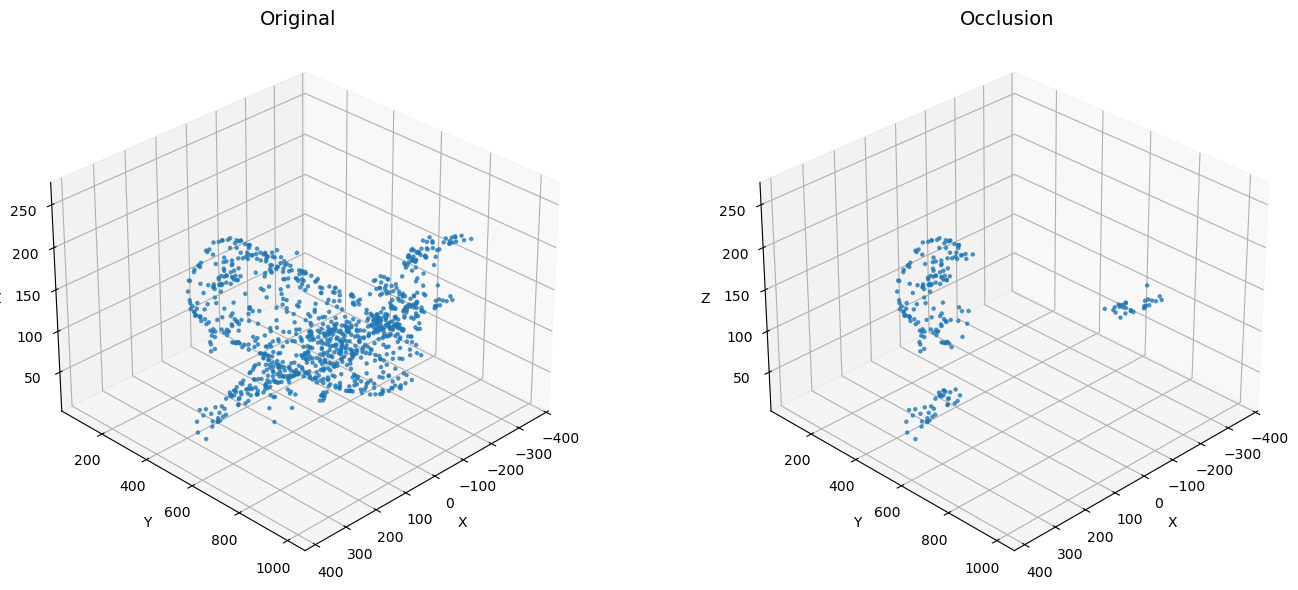

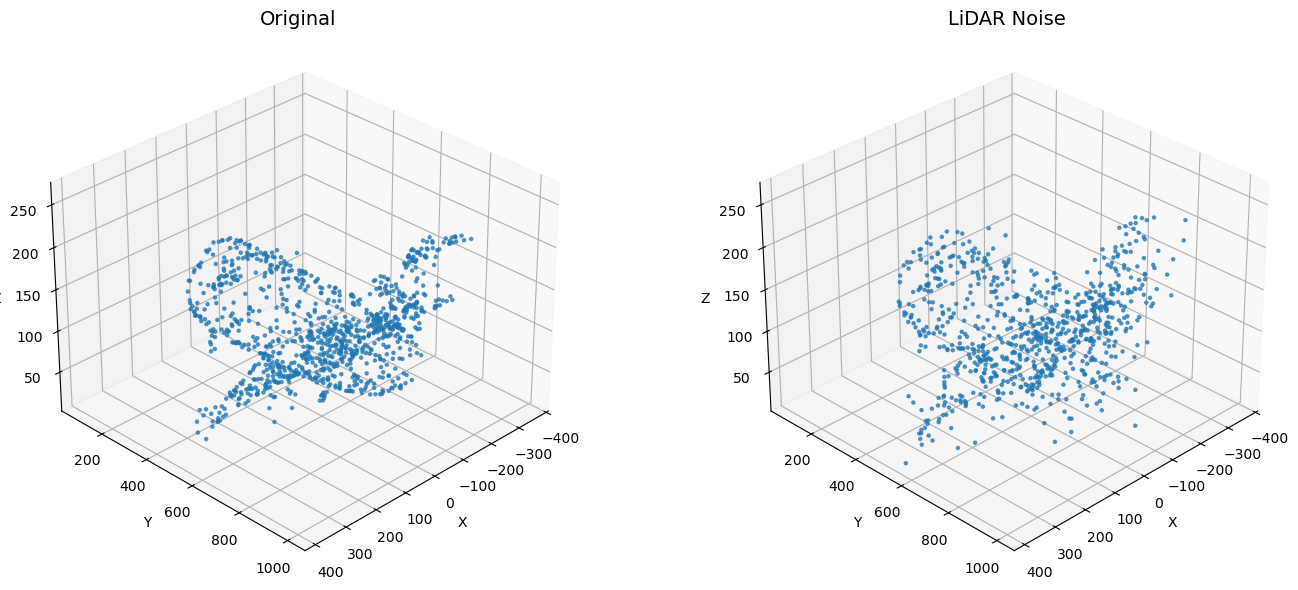

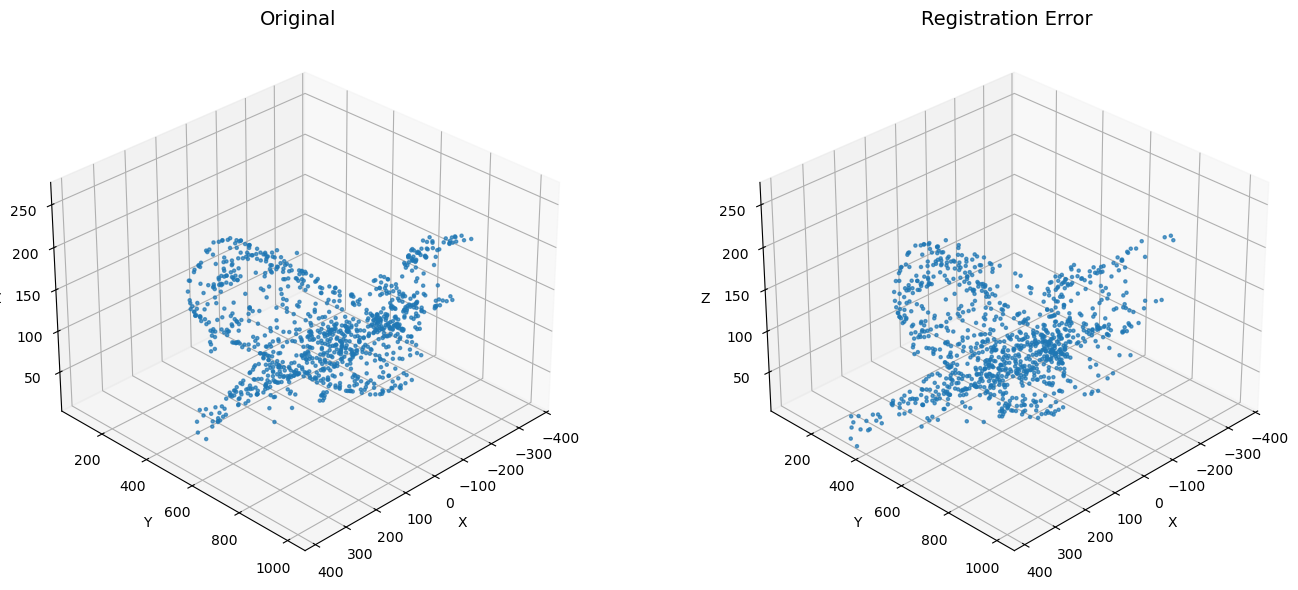

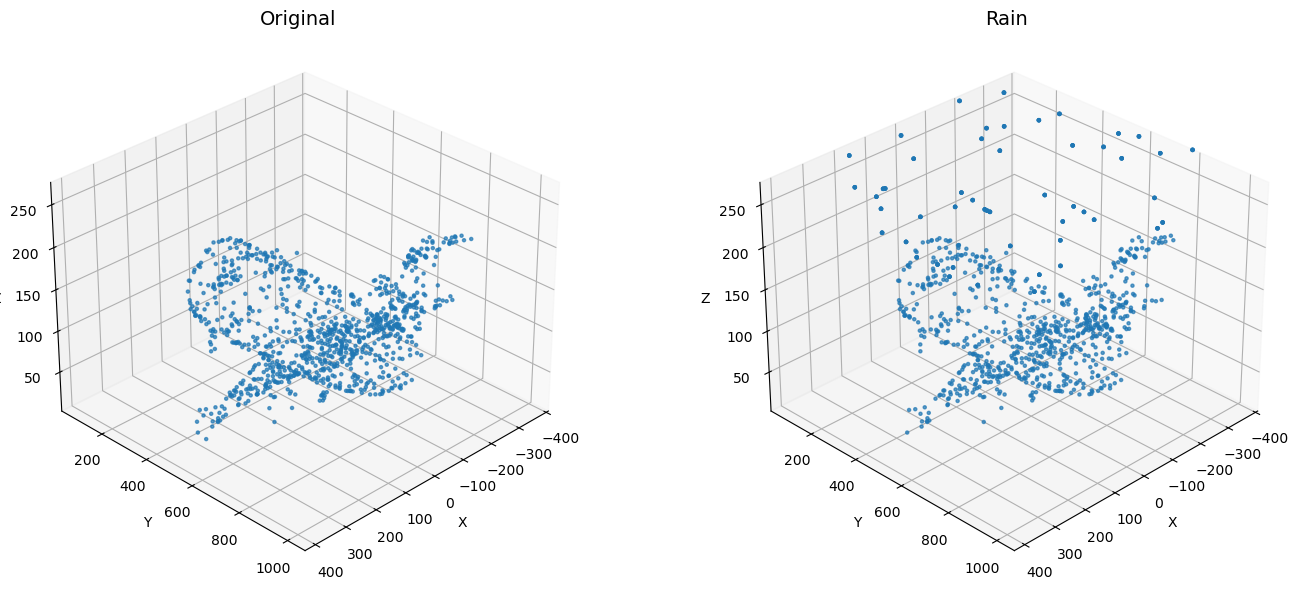

In [15]:
# Get a batch of point clouds for visualization
points, _ = next(iter(small_test_loader))

# Visualize occlusion with more dramatic settings
occluded_points = add_occlusion(points, num_spheres=10, occlusion_radius=200)
visualize_corruption(points, occluded_points, 'Occlusion')

# Visualize LiDAR noise
lidar_points = add_lidar_noise(points, distance_noise=0.03, reflectivity_drop=0.2)
visualize_corruption(points, lidar_points, 'LiDAR Noise')

# Visualize registration errors
misaligned_points = add_registration_error(points, rotation_error=0.5, translation_error=0.4)
visualize_corruption(points, misaligned_points, 'Registration Error')

# Visualize rain
rainy_points = add_rain(points, rain_density=0.05, rain_length=0.2)
visualize_corruption(points, rainy_points, 'Rain')

### Step 6: Training and Evaluation Pipeline

This section provides a simple training and evaluation loop for the custom model, supporting clean, adversarial, and corrupted data.

You can toggle between clean, adversarial, and corrupted training/evaluation by changing the `mode` argument.

In [16]:
# Data augmentation for point clouds

def random_rotate_point_cloud(points):
    """Randomly rotate the point cloud along the up-axis (z)."""
    B, N, C = points.shape
    angles = torch.rand(B) * 2 * np.pi
    cos_vals = torch.cos(angles)
    sin_vals = torch.sin(angles)
    rotation_matrices = torch.zeros((B, 3, 3), device=points.device)
    rotation_matrices[:, 0, 0] = cos_vals
    rotation_matrices[:, 0, 1] = -sin_vals
    rotation_matrices[:, 1, 0] = sin_vals
    rotation_matrices[:, 1, 1] = cos_vals
    rotation_matrices[:, 2, 2] = 1
    rotated = torch.bmm(points, rotation_matrices)
    return rotated

def random_jitter_point_cloud(points, sigma=0.01, clip=0.05):
    """Randomly jitter points. jittering is per point."""
    jitter = torch.clamp(sigma * torch.randn_like(points), -clip, clip)
    return points + jitter

# Update train_one_epoch to use augmentation

def train_one_epoch(model, loader, optimizer, device, mode='clean', attack_params=None, corruption_fn=None, augment=True):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    for points, labels in loader:
        points, labels = points.to(device), labels.to(device)
        if augment:
            points = random_rotate_point_cloud(points)
            points = random_jitter_point_cloud(points)
        optimizer.zero_grad()
        # For adversarial training, compute attack in eval mode, then train on adv examples
        if mode == 'fgsm':
            model.eval()
            points = fgsm_attack(model, points, labels, **attack_params)
            model.train()
        elif mode == 'pgd':
            model.eval()
            points = pgd_attack(model, points, labels, **attack_params)
            model.train()
        elif mode == 'corrupt' and corruption_fn is not None:
            points = corruption_fn(points)
        outputs = model(points)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * points.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += points.size(0)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

def evaluate(model, loader, device, mode='clean', attack_params=None, corruption_fn=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    for points, labels in loader:
        points, labels = points.to(device), labels.to(device)
        if mode == 'fgsm':
            # Enable grad for attack, then disable for forward
            points_adv = points.clone().detach().requires_grad_(True)
            outputs = model(points_adv)
            loss = F.cross_entropy(outputs, labels)
            # Compute grad outside of no_grad context
            grad = torch.autograd.grad(loss, points_adv)[0]
            adv_points = points + attack_params['epsilon'] * grad.sign()
            adv_points = adv_points.detach()
            outputs = model(adv_points)
            loss = F.cross_entropy(outputs, labels)
            points = adv_points
        elif mode == 'pgd':
            adv_points = pgd_attack(model, points, labels, **attack_params)
            outputs = model(adv_points)
            loss = F.cross_entropy(outputs, labels)
            points = adv_points
        elif mode == 'corrupt' and corruption_fn is not None:
            points = corruption_fn(points)
            outputs = model(points)
            loss = F.cross_entropy(outputs, labels)
        else:
            outputs = model(points)
            loss = F.cross_entropy(outputs, labels)
        total_loss += loss.item() * points.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += points.size(0)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplePointNet(num_classes=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 7

In [18]:

# Clean training
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, optimizer, device, mode='clean', augment=True)
    val_loss, val_acc = evaluate(model, small_test_loader, device, mode='clean')
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


: 

In [ ]:
# Adversarial training (FGSM example)
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, optimizer, device, mode='fgsm', attack_params={'epsilon':0.02})
    val_loss, val_acc = evaluate(model, small_test_loader, device, mode='fgsm', attack_params={'epsilon':0.02})
    print(f"[FGSM] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

In [ ]:
# Adversarial training (PGD example)
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, optimizer, device, mode='pgd', attack_params={'epsilon':0.02})
    val_loss, val_acc = evaluate(model, small_test_loader, device, mode='pgd', attack_params={'epsilon':0.02})
    print(f"[PGD] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


In [ ]:
# Adversarial training (corruption example)
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, optimizer, device, mode='corrupt', attack_params={'epsilon':0.02, 'alpha':0.01, 'num_iter':10})
    val_loss, val_acc = evaluate(model, small_test_loader, device, mode='corrupt', attack_params={'epsilon':0.02, 'alpha':0.01, 'num_iter':10})
    print(f"[CORRUPT] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")